# Estimate transient forcing

In [68]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import my_functions as f
importlib.reload(f) # needed to load new changes in my_functions
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.max_open_warning': 0})

saveforcingdata = True # create one file for each model/member, combine them later if needed
saveforcingfigure = True
save_tasdiff = True


In [69]:
## Find models with abrupt-4xCO2 experiments 
## (necessary condition to make other forcing estimates)

experiments = {}
directory = '../Processed_data/Global_annual_anomalies/'
model_names = [ f.name for f in os.scandir(directory) if f.is_dir() and f.name !='.ipynb_checkpoints']
model_names.sort()
exp = 'abrupt-4xCO2'

for model in model_names:
    modeldirectory = os.path.join(directory, model)
    modelexp_names = [ f.name for f in os.scandir(modeldirectory) if f.is_dir() and f.name !='.ipynb_checkpoints']
    if exp in modelexp_names:
        experiments[model] = {}
        experiments[model][exp] = f.find_members(model, exp)
models = experiments.keys()


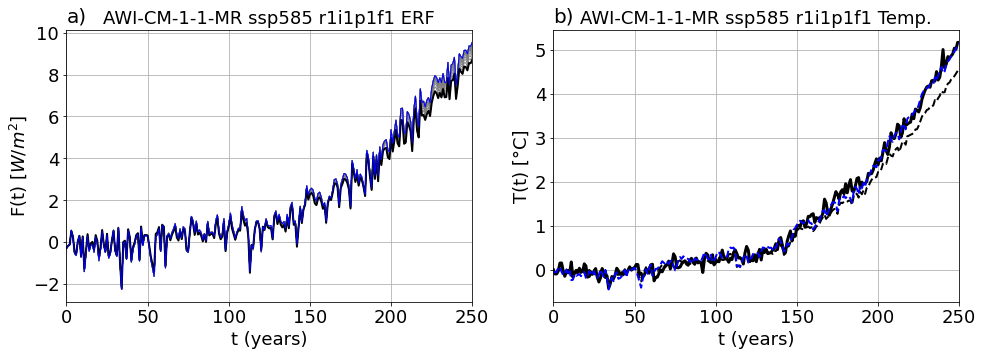

In [74]:
units = [' [K]', ' [W/$m^2$]', ' [W/$m^2$]', ' [W/$m^2$]']
importlib.reload(f)

# choose experiment:
exp = 'ssp585'

#for model in models:
for model in ['AWI-CM-1-1-MR']:
    modeldirectory = os.path.join(directory, model)
    modelexp_names = [ f.name for f in os.scandir(modeldirectory) if f.is_dir() and f.name !='.ipynb_checkpoints']
    if exp in modelexp_names:
        members = f.find_members(model, exp)
    else:
        continue

    for member in members:
    #for member in ['r1i1p1f2']:

        data = f.load_anom(model, exp, member)
        if data.empty:
            print('Empty dataframe for', model, exp, member)
            continue
        
        # if ssp experiment, then we need to include the response
        # generated by historical forcing
        # (for other experiments that branch from piControl,
        # previous forcing, and hence the temperature response
        # to previous forcing is supposed to be 0)
        if exp[:3] == 'ssp':
            # load historical data also and concatenate
            historical_members = f.find_members(model, 'historical')
            if member in historical_members:
                historical_data = f.load_anom(model, 'historical', member)
                data = pd.concat([historical_data, data], ignore_index = True)
            else:
                print('Corresponding historical member does not exist for', model, exp, member)
        
        years = np.arange(0, len(data));
        N = data['rsdt'] - data['rsut'] - data['rlut']
        if model == 'AWI-CM-1-1-MR':
            if exp[:3] == 'ssp' or exp == 'historical':
                data['tas'][0]=0 # set an approximate value since it does not exist for some reason...
        #variables = list(data)
        
        #f.plot_allvar_preloaded(years, data, model, member, plot_title = model + ' ' + exp + ' ' + member)
        #f.plot_tasandN(years, data['tas'], N, plot_title = model + ' ' + exp + ' ' + member)

        F = f.forcing_F13(data['tas'], N, model)

        # load parameters needed to make new forcing estimate:
        filename = 'best_estimated_parameters_allmembers.txt'

        parameter_table = pd.read_table('../Estimates/' + filename,index_col=0)
        taulist = np.array(parameter_table.loc[model,'tau1':'tau3'])
        a_n = np.array(parameter_table.loc[model,'a_1':'a_4'])
        b_n = np.array(parameter_table.loc[model,'b_1':'b_4'])
        F2x = parameter_table.loc[model,'F2x']
        T2x = parameter_table.loc[model,'T2x']

        dim = len(taulist)
        if any(a_n == 0):
            dim = np.count_nonzero(a_n[:dim])
            zeroindex = np.where(a_n == 0)[0]
            a_n = np.delete(a_n,zeroindex)
            b_n = np.delete(b_n,zeroindex)
            taulist = np.delete(taulist,zeroindex)
        fbparlist = (b_n/a_n)[:dim]
        amplitudes = a_n[:dim]/(2*F2x*taulist)

        t = np.arange(0,len(F))
        #tas_pred = f.tas_predictors(t, taulist, exptype = 'timevaryingforcing', timevaryingforcing = F)
        #Tn = amplitudes*tas_pred

        # Compute new estimate of forcing
        it = 20  # number of iterations
        Fiarray = np.full((len(F),it),np.nan)
        Tiarray = np.full((len(F),it),np.nan)

        Fi = F
        for i in range(0,it):
            tas_pred = f.tas_predictors(t, taulist, exptype = 'timevaryingforcing',\
                                        timevaryingforcing = Fi)
            Tni = amplitudes*tas_pred
            Fi = N + Tni@fbparlist
            Fiarray[:,i] = Fi; Tiarray[:,i] = np.sum(Tni,axis=1)

        #f.plot_components(years, Tn, taulist)

        f.forcing_response_figure(years, Fiarray, Tiarray, Tcoupled = data['tas'], titlestr = model + ' ' + exp + ' ' + member)

        if saveforcingfigure == True:
            plt.savefig('../Figures/Transient_forcing_response/' + model + '_' + exp + '_' + member + '_forcing_and_response.pdf', format='pdf', dpi=600, bbox_inches="tight")
        #plt.close()

        if saveforcingdata == True:
            # create model directory if it does not already exist
            modelexpdir = os.path.join('../Estimates/Transient_forcing_estimates/', model, exp)
            if os.path.isdir(modelexpdir) == False:
                os.makedirs(modelexpdir)
            index = pd.Index(years, name='Year')

            # save files
            if exp[:3] == 'ssp':
                expstr = 'historicaland' + exp
            else:
                expstr = exp
            df_F13 = pd.DataFrame(F.values, index=index, columns=['ERF'])
            modelfilename = model + '_' + expstr + '_' + member + '_F13_ERF.txt'
            df_F13.to_csv(modelexpdir + '/' + modelfilename, sep='\t')

            df_F = pd.DataFrame(Fiarray[:,-1], index=index, columns=['ERF'])
            modelfilename = model + '_' + expstr + '_' + member + '_ERF.txt'
            df_F.to_csv(modelexpdir + '/' + modelfilename, sep='\t')

        if save_tasdiff == True:
            # save difference between linear response to new forcing and coupled model tas
            tas_diff = Tiarray[:,-1] - data['tas']
            index = pd.Index(years, name='Year')
            df_tas = pd.DataFrame(tas_diff.values, index=index, columns=['tas_diff'])
            tas_filename = model + '_' + expstr + '_' + member + '_tas_diff.txt'
            df_tas.to_csv(modelexpdir + '/' + tas_filename, sep='\t')


